In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.utils import resample
from sklearn.metrics import r2_score, ndcg_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from scipy.stats import spearmanr

import sys
sys.path.append('..')
from util.Datasets import *

In [2]:
file_name = 'AE+Triad_rank_GB1'
embeddings = np.load('/home/jyang4/ProtTP/saved/{}/embeddings.npy'.format(file_name))
reconstructions = np.load('/home/jyang4/ProtTP/saved/{}/reconstructions.npy'.format(file_name))

In [5]:
FILEPATH = '/home/jyang4/ProtTP/data/GB1_AllPreds.csv'
dataframe = pd.read_csv(FILEPATH)
dataset = GB1Dataset(dataframe=dataframe, encoding='one-hot', attribute_names=["Triad-FixedBb-dG"])

In [ ]:
FILEPATH = '/home/jyang4/ProtTP/data/PABP_AllPreds.csv'
dataframe = pd.read_csv(FILEPATH)
dataset = PABPDataset(dataframe=dataframe, encoding='one-hot', attribute_names=['EVMutation'])

In [3]:
np.sum(reconstructions, axis =1)

array([4.488838 , 3.8384495, 4.2259183, ..., 3.6764045, 3.6011784,
       4.1556196], dtype=float32)

In [7]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(embeddings)
dataset.data[['PCA 1', 'PCA 2']] = transformed

#plot the high fitness values last
dataset.data = dataset.data.sort_values('Fitness')#'log_fitness'
pca.explained_variance_ratio_

array([0.97512012, 0.00729856])

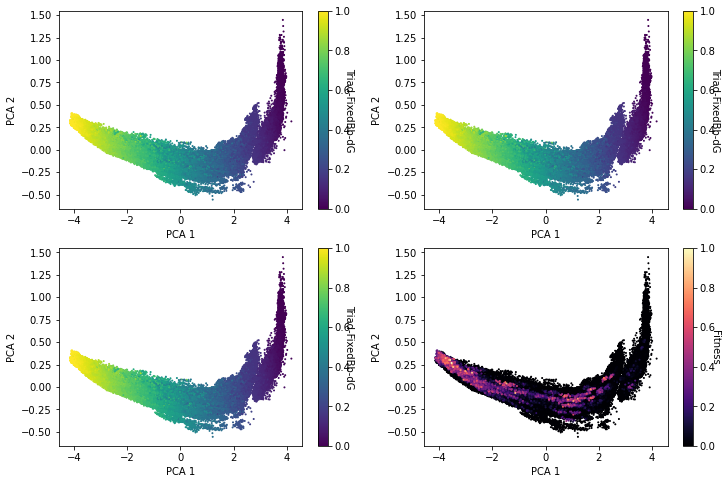

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

for i, attribute in enumerate(["Triad-FixedBb-dG", "Triad-FixedBb-dG", "Triad-FixedBb-dG", 'Fitness']):
#for i, attribute in enumerate(['Triad-FixedBb-dG', 'EvMutation', 'esm_msa1_t12_100M_UR50S-Naive-ColumnUnmasked', 'Fitness']):
    ax = axs.reshape(-1)[i]
    if i == 3:
        color = 'magma'
    else:
        color = 'viridis'
    
    ax.scatter(data=dataset.data, x='PCA 1', y='PCA 2', s=1, c=attribute, cmap=color)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=color), ax=ax)
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    cbar.set_label(attribute, rotation=270)

plt.savefig('{}.jpg'.format(file_name))